# Download requirements

In [ ]:
install.packages('fpp2')

In [1]:
library(fpp2)

Warning message:
"package 'fpp2' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
-- Attaching packages ---------------------------------------------- fpp2 2.4 --
v ggplot2   3.1.1     v fma       2.4  
v forecast  8.14      v expsmooth 2.3  
Warning message:
"package 'forecast' was built under R version 3.6.3"Warning message:
"package 'fma' was built under R version 3.6.3"Warning message:
"package 'expsmooth' was built under R version 3.6.3"


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Predict cho Durbl portfolio

#### Lấy dữ liệu của Durbl porfolio

In [4]:
series <- ts(data = data$Durbl, start = c(1963,7), end = c(2022,4), frequency = 12)

In [5]:
series %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-32.930  -2.857   0.820   1.004   4.463  45.270 

#### Khảo sát tập train từ 7/1963 - 12/1989

In [6]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [7]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale

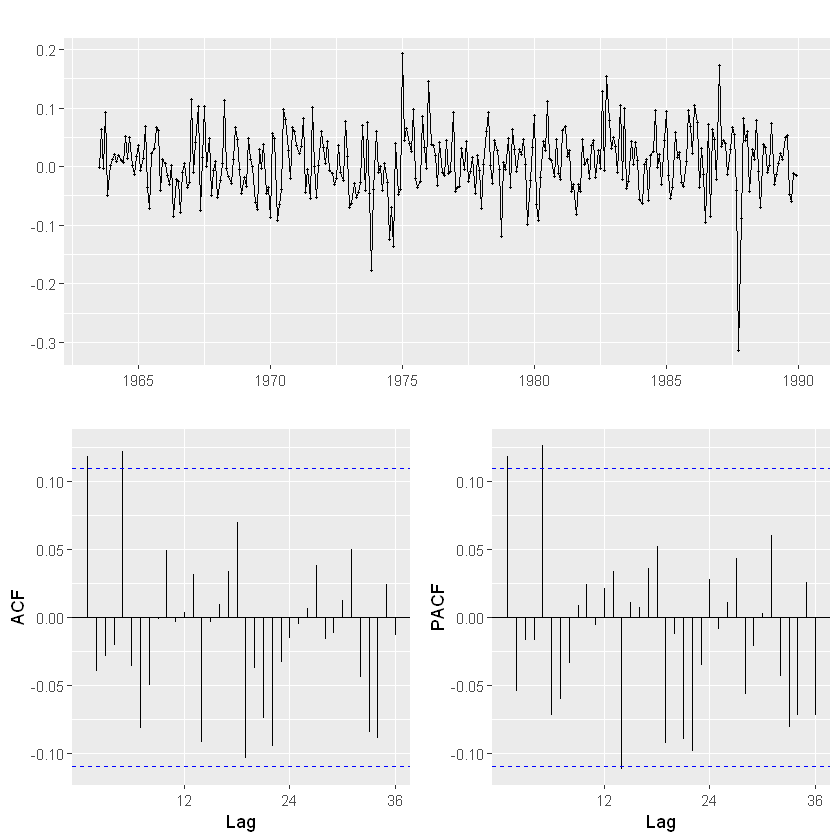

In [8]:
series_train %>% ggtsdisplay()

Biểu đồ dao động không có trend và seasonality quan sát được, nên không cần lấy difference và seasonal difference. <br>
Thử lại với hàm dò tìm bậc d: ndiffs cho order và nsdiffs cho seasonal.

In [9]:
series_train %>% ndiffs()

[1] 0

In [10]:
series_train %>% nsdiffs()

[1] 0

Kết quả d = 0 cho cả order và seasonal.

#### Phân tích p và q cho mô hình ARIMA

Thử dò tìm (p,d,q) với chế độ auto theo thuật toán Hyndman-Khandakar.

In [11]:
fit <- auto.arima(series_train, stepwise = FALSE, approximation = FALSE)
fit

Series: series_train 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
         ma1    mean
      0.1297  0.0074
s.e.  0.0575  0.0035

sigma^2 estimated as 0.003018:  log likelihood=472.48
AIC=-938.97   AICc=-938.89   BIC=-927.68


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with non-zero mean
Q* = 24.928, df = 22, p-value = 0.3005

Model df: 2.   Total lags used: 24



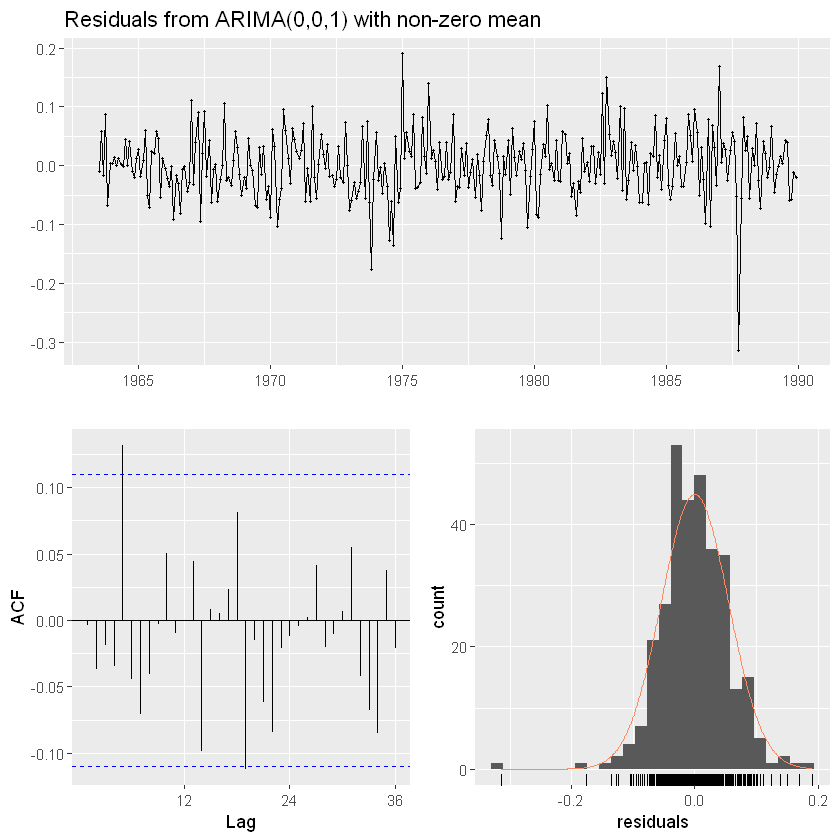

In [12]:
fit %>% checkresiduals()

Auto đề xuất ARIMA(0,0,1), Ljung-Box test cho p-value > 0.05 nên mô hình phù hợp.

Thử tất cả các mô hình đề xuất và so sánh theo tiêu chuẩn thông tin AIC, AICc, BIC, RMSE.

In [13]:
model <- list(ARIMA000 = c(0,0,0), ARIMA001 = c(0,0,1), ARIMA002 = c(0,0,2), ARIMA100 = c(1,0,0), ARIMA101 = c(1,0,1), 
              ARIMA102 = c(1,0,2), ARIMA200 = c(2,0,0), ARIMA201 = c(2,0,1), ARIMA202 = c(2,0,2))

In [14]:
result <- NULL
for (m in model)
{
    fit <- Arima(series_train, order = m)
    fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
    rmse <- sqrt(mean((log_inv(series_train) - fitted)^2))
    result <- rbind(result, c(AIC = fit$aic, AICc = fit$aicc, BIC = fit$bic, RMSE = rmse))
}
row.names(result) <- names(model)
result

,AIC,AICc,BIC,RMSE
ARIMA000,-936.0208,-935.9827,-928.4967,5.519404
ARIMA001,-938.9667,-938.8903,-927.6806,5.482661
ARIMA002,-937.4233,-937.2955,-922.3751,5.478744
ARIMA100,-938.5258,-938.4493,-927.2396,5.485686
ARIMA101,-938.2233,-938.0955,-923.1751,5.469458
ARIMA102,-940.6594,-940.4671,-921.8491,5.412079
ARIMA200,-937.4705,-937.3427,-922.4223,5.478554
ARIMA201,-936.8884,-936.6961,-918.0782,5.465025
ARIMA202,-934.8930,-934.6229,-912.3207,5.465067


Mô hình ARIMA(1,0,2) cho kết quả RMSE thấp nhất trên tập train.

#### Đánh giá mô hình ARIMA(1,0,2) trên tập test

In [7]:
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end = length(series)-388+i) %>% log_scale
    fit <- Arima(train, order = c(1,0,2))
    pred <- c(pred, forecast(fit, h = 1)$mean %>% log_inv) 
}
pred <- ts(data = pred, start = c(1990,1), frequency = 12)
true <- series %>% window(start = c(1990,1))
rmse <- sqrt(mean((true-pred)^2))
rmse

[1] 7.817998

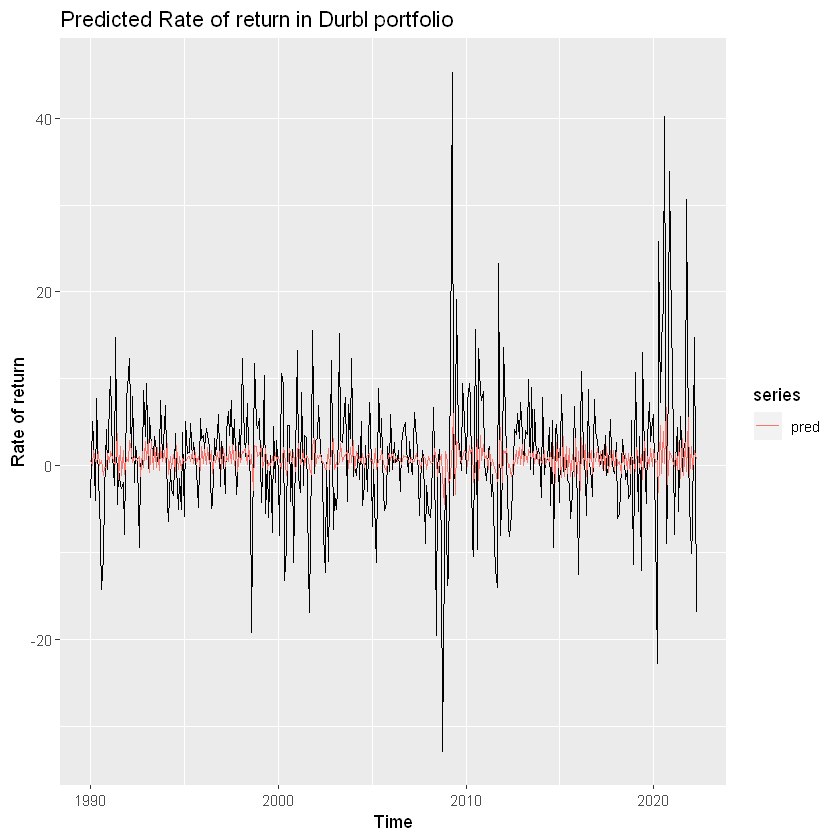

In [8]:
autoplot(true) + autolayer(pred) + labs(y = "Rate of return", title = "Predicted Rate of return in Durbl portfolio")

In [9]:
as.numeric(pred)

[1]  0.56467308  0.02338698  1.68724968  0.51719298  0.37896340  1.64469654
  [7]  0.02043821  0.55202103 -1.10336298 -0.19283631 -0.27266576  1.38309801
 [13]  0.35348325  1.67390883  0.95122520  0.23825441  0.09567265  3.70373096
 [19] -1.55254936  2.16150841 -1.14021108  1.77904590 -1.02853369  0.88626659
 [25]  0.49464368  2.90309777  1.74573104  0.34579996  0.99186911  0.75141052
 [31]  0.60777742  0.99121203 -1.26551109  1.59874375 -0.19493795  2.72253643
 [37]  0.69030955  3.01135974 -0.79869044  2.76042635 -0.48873099  2.16523010
 [43] -0.21958221  2.13657545 -0.51249607  2.03941430  0.46591497  1.76640229
 [49]  0.30563383  2.55404715 -1.07683752  1.02797482 -0.29654808  1.29027877
 [55] -0.71096538  2.28303071 -0.50955767  1.02805544 -0.43256326  0.86990038
 [61]  0.46240024  0.38320516  0.98475612  1.07152432  0.51362879  1.62445198
 [67]  0.26296354  1.47562781  0.21029802  1.07610664 -0.53962527  2.15632874
 [73]  0.19248658  1.88157600  0.07923861  2.04586067  0.23256457  1.76612469
 [79] -0.85696531  1.07231285  0.29842987  1.55073597  0.41267175  2.11868085
 [85] -0.50254535  1.93938744 -0.15622098  1.10208421  0.48086234  2.15494125
 [91]  0.28698431  2.38984241 -0.04639510  2.24992962 -0.70541768  1.51860355
 [97]  0.35196254  1.56474774  1.45809427  1.98350338  0.14869639  2.36563746
[103]  0.13797611  1.30977087 -2.85813050  2.32186042  2.22940140  1.04183870
[109]  1.24411389  2.32135110 -0.18405196  0.63401870  2.01953633 -0.42157583
[115]  0.29660248 -0.03217422  1.09379872  0.03963755  1.48252363  0.54774099
[121]  1.02106928  0.63214069 -0.32038193  2.11063985  1.55398929 -1.18915055
[127] -0.04981088  1.98437298  1.40631496  0.23375771  1.45615838 -0.65826229
[133]  1.54669752  2.49699347  0.12936525  0.39504227  1.82141545  0.05972714
[139]  1.17418778  0.85383795 -0.34642469 -0.97935028  2.22746499  3.14319865
[145] -0.08010009  1.20044006  0.81139207  1.27660659  0.34334524  0.37085939
[151] -0.50514219 -0.47900190  1.95034464 -0.48274775  1.40980179  3.07585533
[157] -0.45423583  0.40092100 -0.16018115  0.47114278  2.50610057  0.48858568
[163]  1.21532050  1.14339380  1.74917991 -0.33832038  2.07931666  0.36898946
[169]  2.87353211 -0.56691382  1.66084729  0.48097641  0.99134678  0.31314058
[175]  1.35858390 -0.18559915  0.68082417  1.13160301  1.39043557  0.48669742
[181]  0.73024665 -0.39408191  1.95346698 -0.39499003  0.55741570  0.70937603
[187]  1.69139579  0.38645018 -0.09087699 -0.71593420  0.50259972  1.35619404
[193]  0.62796432  1.56592927  0.35776538  1.01880228  0.51360354  0.68905548
[199]  0.78380836  0.16846376  1.11355906  1.05290402  1.02823607  0.47558716
[205]  0.29462559  0.90915043  0.33155193  0.47153006  1.34369657  0.64307321
[211]  0.59065650 -0.31115919  0.67981712  1.02638674  0.78150975 -0.46379753
[217]  1.04742761  0.35091822  0.26839961  0.42717092  1.95824414  0.63974940
[223] -1.29573759  0.32891675  1.22334951 -1.26699707 -4.43668160  1.60569602
[229]  0.51334533 -1.97319916 -1.37996468  2.83017690  6.05227682 -3.28693023
[235]  2.71553531  2.46578111  1.15612808  0.31953770  0.85978908  1.74855879
[241]  1.41905963 -0.08944084  2.29853180  1.41128703  2.05508921 -1.97099032
[247] -0.43167735  3.00627823 -1.68860103  3.47436227  0.59780729  2.46796697
[253]  0.81965444  1.21672597 -0.44362010  1.69676692  0.04463981  0.67791694
[259] -0.16812995 -0.41760566 -1.83275209 -1.28542240  4.36713330 -1.94398790
[265]  1.71121254  1.39576922  1.91844826 -0.21474850  0.15872099 -1.23998168
[271]  0.52961938  0.04561879  1.76858800  0.29248073  2.07363289  0.08189950
[277]  2.43809569 -0.01396371  1.38781002  0.34435215  1.80608586  1.27229932
[283]  0.75745691  1.66866485  0.24267134  1.72811156  0.27721903  1.22954734
[289]  0.34429742  0.29427930  1.74526929  0.10287978  0.90987339  0.44196459
[295]  1.53649371 -0.67691190  2.14722470 -1.92399066  2.65950726 -0.24074589
[301]  1.92176658 -1.37161734  3.32651561 -1.30622703  2.24480680 -0.93898901
[307]  2.01664688 -1.271